In [ ]:
#Mounting the google drive to colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls

drive/  sample_data/


In [ ]:
cd drive/

/content/drive


In [ ]:
cd MyDrive/

/content/drive/MyDrive


In [ ]:
cd CMPE-255-Group-Project-FALL21/

/content/drive/MyDrive/CMPE-255-Group-Project-FALL21


In [ ]:
ls

 classifiers/   dl.ipynb                  README.md
 data/         'Project Documentation'/   Vectorizers/


In [ ]:

#Importing the libraries
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
import numpy as np 
import matplotlib.pyplot as plt
import os

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Embedding
import seaborn as sns

In [ ]:
#reading the dataset
data = pd.read_json('./data/News_Category_Dataset_v2.json', lines=True)

In [ ]:
data

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26
...,...,...,...,...,...,...
200848,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,"Reuters, Reuters",https://www.huffingtonpost.com/entry/rim-ceo-t...,Verizon Wireless and AT&T are already promotin...,2012-01-28
200849,SPORTS,Maria Sharapova Stunned By Victoria Azarenka I...,,https://www.huffingtonpost.com/entry/maria-sha...,"Afterward, Azarenka, more effusive with the pr...",2012-01-28
200850,SPORTS,"Giants Over Patriots, Jets Over Colts Among M...",,https://www.huffingtonpost.com/entry/super-bow...,"Leading up to Super Bowl XLVI, the most talked...",2012-01-28
200851,SPORTS,Aldon Smith Arrested: 49ers Linebacker Busted ...,,https://www.huffingtonpost.com/entry/aldon-smi...,CORRECTION: An earlier version of this story i...,2012-01-28


                                                            # Data Cleaning


In [ ]:
data.drop(['authors', 'link', 'date'], axis = 1, inplace = True) #dropping the authors,link and date columns as they are not useful

In [ ]:
data

,category,headline,short_description
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,She left her husband. He killed their children...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Of course it has a song.
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,The actor and his longtime girlfriend Anna Ebe...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,The actor gives Dems an ass-kicking for not fi...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,"The ""Dietland"" actress said using the bags is ..."
...,...,...,...
200848,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,Verizon Wireless and AT&T are already promotin...
200849,SPORTS,Maria Sharapova Stunned By Victoria Azarenka I...,"Afterward, Azarenka, more effusive with the pr..."
200850,SPORTS,"Giants Over Patriots, Jets Over Colts Among M...","Leading up to Super Bowl XLVI, the most talked..."
200851,SPORTS,Aldon Smith Arrested: 49ers Linebacker Busted ...,CORRECTION: An earlier version of this story i...


In [ ]:
data['news'] = data[['headline', 'short_description']].agg(' '.join, axis=1) #combining headline and short description columns into a single column called news

In [ ]:

data.drop(['short_description', 'headline'], axis = 1, inplace = True)

In [ ]:
data

,category,news
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 5...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...
...,...,...
200848,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...
200849,SPORTS,Maria Sharapova Stunned By Victoria Azarenka I...
200850,SPORTS,"Giants Over Patriots, Jets Over Colts Among M..."
200851,SPORTS,Aldon Smith Arrested: 49ers Linebacker Busted ...


In [ ]:
data['words_length'] = data.news.apply(lambda i: len(i.split(" ")))
data = data[data.words_length >= 5]

In [ ]:
data.describe()

,words_length
count,200367.000000
mean,29.448557
std,13.905755
min,5.000000
25%,20.000000
50%,28.000000
75%,35.000000
max,245.000000


In [ ]:
data = data[data['category'].map(data['category'].value_counts()) > 3000]

data.category = data.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
data

,category,news,words_length
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,27
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,20
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 5...,25
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,25
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,26
...,...,...,...
200839,ENTERTAINMENT,'Girl With the Dragon Tattoo' India Release Ca...,37
200849,SPORTS,Maria Sharapova Stunned By Victoria Azarenka I...,30
200850,SPORTS,"Giants Over Patriots, Jets Over Colts Among M...",41
200851,SPORTS,Aldon Smith Arrested: 49ers Linebacker Busted ...,28


In [ ]:
data['category'].value_counts()

POLITICS          32669
WELLNESS          17826
ENTERTAINMENT     16036
TRAVEL             9873
STYLE & BEAUTY     9648
PARENTING          8677
HEALTHY LIVING     6631
QUEER VOICES       6307
FOOD & DRINK       6225
BUSINESS           5919
COMEDY             5060
SPORTS             4875
BLACK VOICES       4521
HOME & LIVING      4194
PARENTS            3951
WORLDPOST          3664
WEDDINGS           3651
WOMEN              3478
IMPACT             3451
DIVORCE            3426
CRIME              3399
Name: category, dtype: int64

In [ ]:
#shuffling the dataset to make the dataset uniform
from sklearn.utils import shuffle
df = shuffle(data)
df.reset_index(inplace=True, drop=True) 

In [ ]:
df

,category,news,words_length
0,SPORTS,The Presidential Debates Should Model Themselv...,23
1,WELLNESS,The Alchemy of Joy We hold the ability to chan...,37
2,WELLNESS,"If You Lead a Student to Vegetables, Will They...",61
3,STYLE & BEAUTY,Fashion's Night Out Ads: New York vs. Los Ange...,30
4,TRAVEL,Sparkling New Caribbean Resort Hotels for 2014...,42
...,...,...,...
163476,PARENTS,How Having Kids Helped Me Grow Up Having child...,56
163477,PARENTS,On Father's Day: 10 Lessons I Learned From My ...,51
163478,WELLNESS,Meditation Tips: Does Meditation Have to Be Se...,54
163479,POLITICS,"Across The Board, The Trump Administration's D...",26


In [ ]:
!pip install contractions

     |████████████████████████████████| 284 kB 5.3 MB/s 
     |████████████████████████████████| 321 kB 36.8 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85446 sha256=cf8575268fa2cb5c9f2f7cc8427c670d630709d3ced22be22e17203f448aa474
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [ ]:
!pip install regex

                                     # Data preprocessing 

In [ ]:
#importing contractions and regex libraries
import contractions
from tqdm import tqdm
import nltk
import regex as re

In [ ]:

clean_reviews=[]
for i in tqdm(df['news']):
    #Rremoving the html tags from the news column
    i=re.sub('(<[\w\s]*/?>)',"",i)
    #Expanding  the contractions i.e for example I'll will be expanded as I will
    i=contractions.fix(i)
    #Removing the special characters from the news 
    i=re.sub('[^a-zA-Z0-9\s]+',"",i)
    #Removing  the digits from the news. We do not need numerical data to classify news
    i=re.sub('\d+',"",i)
    #Converting the higher case letters to lowe r case letters
    i=i.lower()
    
    clean_reviews.append(i)

100%|██████████| 163481/163481 [00:07<00:00, 20722.23it/s]


In [ ]:

df=pd.DataFrame({'news':clean_reviews,'category':list(df['category']),'words_length':list(df['words_length'])})

In [ ]:
df['words_length'] = df.news.apply(lambda i: len(i.split(" ")))
df = df[df.words_length >= 5]

In [ ]:
df

,news,category,words_length
0,the presidential debates should model themselv...,SPORTS,23
1,the alchemy of joy we hold the ability to chan...,WELLNESS,37
2,if you lead a student to vegetables will they ...,WELLNESS,61
3,fashions night out ads new york vs los angeles...,STYLE & BEAUTY,30
4,sparkling new caribbean resort hotels for if ...,TRAVEL,43
...,...,...,...
163476,how having kids helped me grow up having child...,PARENTS,56
163477,on fathers day lessons i learned from my gran...,PARENTS,51
163478,meditation tips does meditation have to be ser...,WELLNESS,55
163479,across the board the trump administrations der...,POLITICS,26


In [ ]:
vocab_size =20000
max_length = 35
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [ ]:
#encoding the labels of the dataset
from sklearn.preprocessing import LabelEncoder as lencoder

le = lencoder()
labels = le.fit_transform(df['category'])

In [ ]:
labels

array([14, 18, 18, ..., 18, 12, 15])

In [ ]:
#changing the labels to categorical
from tensorflow.keras.utils import to_categorical
labels= to_categorical(labels,num_classes=21)

In [ ]:
labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
#Tokenizing the data
X,Y = df['news'],df['category']
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

word_index = tokenizer.word_index

X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen= max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
X

array([[   2,  399, 3391, ...,    0,    0,    0],
       [   2,    1,    5, ..., 4679,   38, 1973],
       [  54,   10,  549, ...,    6, 4096,  283],
       ...,
       [ 895,  260,  103, ...,   98,  182,    4],
       [ 521,    2, 1260, ...,    0,    0,    0],
       [2037,   20, 3699, ...,    0,    0,    0]], dtype=int32)

In [ ]:
#Splitting the train, test and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, labels, test_size=0.2, random_state=42,stratify=labels)
X_val, X_test , y_val, y_test= train_test_split(X_val,y_val, test_size=0.5, random_state=42)

In [ ]:
X_train

array([[  661,   882,   820, ...,     0,     0,     0],
       [ 1274,     1,  3682, ...,     0,     0,     0],
       [   27,   129,   737, ...,   119,  1145,     3],
       ...,
       [ 1576,     8, 12143, ...,     3,     2,   341],
       [ 5949,    35,    30, ...,    33,    35,   103],
       [11622, 14717,  1284, ...,    26,  1965,     0]], dtype=int32)

In [ ]:
X_val

array([[12111,    81,   122, ...,     0,     0,     0],
       [ 4868,   318,  3587, ...,   378,     3,    36],
       [ 1337,     1,    23, ...,   198,    29,    62],
       ...,
       [   68, 10626,   173, ...,  2572,   316,     0],
       [ 2113,  6716,   862, ...,     0,     0,     0],
       [ 2506,     1, 18458, ...,     5,   241,  4566]], dtype=int32)

In [ ]:
num_words=20000
embeddings=300

In [ ]:
from keras.layers import Embedding,Conv1D,LSTM,GRU,BatchNormalization,Flatten,Dense
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

In [ ]:

# Building the LSTM model
model= Sequential()
model.add(Embedding(num_words,embeddings,input_length=max_length))
model.add(keras.layers.Bidirectional(LSTM(256,return_sequences=True)))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.GRU(256))
model.add(keras.layers.Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(Dense(21,activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 35, 300)           6000000   
                                                                 
 bidirectional_22 (Bidirecti  (None, 35, 512)          1140736   
 onal)                                                           
                                                                 
 dropout_27 (Dropout)        (None, 35, 512)           0         
                                                                 
 gru_2 (GRU)                 (None, 256)               591360    
                                                                 
 dropout_28 (Dropout)        (None, 256)               0         
                                                                 
 dense_22 (Dense)            (None, 64)                16448     
                                                     

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy']
             )

In [ ]:
#checking if the GPU is available or not
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
#Implementing the early stopping as callback so that the model won't overfit
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                            patience=3, min_delta=0.0001)

In [ ]:
#Training the model
history = model.fit( X_train,y_train,validation_data=(X_val,y_val), epochs=10, batch_size=32,steps_per_epoch=len(X_train) // 32,validation_steps = len(X_val)//32, callbacks=early_stop) 

In [2]:
#testing the model
score, acc = model.evaluate(X_test, y_test)

511/511 [==============================] - 10s 20ms/step - loss: 1.1629 - accuracy: 0.7247


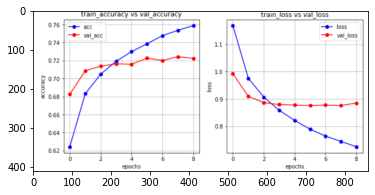

<Figure size 720x720 with 0 Axes>

In [9]:
#Plotting the Loss and Accuracy graphs
fig = plt.figure(figsize=(5,5))
plt.subplot(221)
plt.plot(history.history['accuracy'],'bo-', label = "acc")
plt.plot(history.history['val_accuracy'], 'ro-', label = "val_acc")
plt.title("train_accuracy vs val_accuracy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()

plt.subplot(222)
plt.plot(history.history['loss'],'bo-', label = "loss")
plt.plot(history.history['val_loss'], 'ro-', label = "val_loss")
plt.title("train_loss vs val_loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()